# Jet Tagging with Graph Neural Networks (GNN)

This notebook shows how to use a GNN for jet classification between QCD and TT jets using particle-level features represented as a graph. Note that you get some GPU time on Kaggle for free (30 hrs/week). This will make training the model here faster, but note that it won't help you with the graph building, which also does take time here. Sadly you can't turn it on just to run the training, the notebook session must be run as either CPU or GPU. If you want to experiment with GNNs and the graph building becomes annoying, just save the graphs, and then load them as you need. 

## What is a GNN?
A Graph Neural Network (GNN) is a type of neural network designed to process graph-structured data. It can learn from both node features and the graph structure. It can be used to predict information about nodes, links between nodes or graphs as a whole. 

## Why use GNNs for Jet Tagging?
- Very flexible, can start from images or dataframes, or use both 
- Has the potential to remove areas where there is no energy deposited
- Has the potential to include long range interactions in a way a CNN can't 
- Can handle variable number of particles

## 1. Load and Prepare Data

We will create the graphs from images, but there are many other ways to do it. 

The energy deposited in a pixel will be the node feature, and we will connect each pixel to its eight closest pixels (up, down, sides, diagonals). 

The graph building function written here has an option to set max_nodes, which will only choose the top n most energetic nodes. There's also an option whether to consider all nodes or not, if you set this to false, it will throw away all the pixels with 0 energy deposited. 

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, GATConv
from torch_geometric.data import Data, DataLoader
import sys
sys.path.append('..')
from utils.data_processing import load_images
from utils.data_processing import create_graph_data
from utils.data_processing import load_processed_data 
from utils.plotting import plot_confusion_matrix, plot_training_history, plot_roc_curve


In [2]:
# Load data
X_train, y_train, train_ids, X_val, y_val, val_ids, X_test, test_ids = load_images()

In [3]:
from utils.data_processing import anti_kt_clustering, extract_cluster_features
from utils.data_loading import process_jet_to_clusters
from torch_geometric.utils import dense_to_sparse

def compute_eccentricity(pt, eta, phi):
    # Compute weighted mean
    eta_mean = (pt * eta).sum() / pt.sum()
    phi_mean = (pt * phi).sum() / pt.sum()
    
    # Center coordinates
    eta_centered = eta - eta_mean
    phi_centered = phi - phi_mean
    
    # Weighted covariance matrix components
    w = pt
    cov_00 = (w * eta_centered * eta_centered).sum() / w.sum()
    cov_01 = (w * eta_centered * phi_centered).sum() / w.sum()
    cov_11 = (w * phi_centered * phi_centered).sum() / w.sum()
    
    cov = torch.tensor([[cov_00, cov_01],
                        [cov_01, cov_11]])
    
    eigvals = torch.linalg.eigvalsh(cov)
    eccentricity = torch.sqrt(1 - eigvals.min() / eigvals.max()).item()
    return eccentricity

def create_cluster_data(jet_images, labels=None, max_nodes=12, test_ids = None):
    data_list=[]
    nodeless=[]
    if labels is None:
        labels = np.zeros(len(jet_images))
    for i, (image, label) in enumerate(zip(jet_images, labels)):
        clusters=anti_kt_clustering(image, R=0.4, pt_min=0.05)
        for j, c in enumerate(clusters):
            cl=c[0].tolist()
            clusters[j]=cl
        clusters=np.array(clusters)
        clusters=clusters[clusters[:, 2].argsort()]
        n_nodes=len(clusters)
        if n_nodes < 2:
            # print(f"Warning: Graph {i} has too few nodes")
            # continue
            if test_ids is not None:
                nodeless.append(test_ids[i])
            else:
                nodeless.append(i)
        if n_nodes > max_nodes:
            # clusters=np.sort(clusters, axis=0)
            clusters=clusters[n_nodes-max_nodes:]
            n_nodes=len(clusters)
        node_features=clusters
        adj_matrix = np.zeros((n_nodes, n_nodes))
        edge_features = np.zeros((n_nodes, n_nodes))
        for k in range(n_nodes):
            indices = np.arange(n_nodes)
            indices = np.delete(indices, k)
            adj_matrix[k, indices] = 1
            adj_matrix[indices, k] = 1  # Make it symmetric
        
        x = torch.FloatTensor(clusters).view(-1, 3)
        adj = torch.ones((n_nodes, n_nodes)) - torch.eye(n_nodes)
        edge_index = dense_to_sparse(adj)[0]  # shape [2, num_edges]

        # Compute edge features as difference between node features
        row, col = edge_index
        edge_attr = x[row] - x[col]  # shape: [num_edges, 3]

        # --- Global features ---
        pt = x[:, 2]
        eta = x[:, 0]
        phi = x[:, 1]
        
        global_features = torch.tensor([
            float(x.shape[0]),               # num_nodes
            # float(pt.var(unbiased=False)),   # var pt
            # float(eta.var(unbiased=False)),  # var eta
            # float(pt.sum()),                 # total pt
            # float(compute_eccentricity(pt, eta, phi))
            float(pt.max()),
            float(eta.abs().max())
        ], dtype=torch.float)

        y_tensor = torch.tensor(label, dtype=torch.float)
        # data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y_tensor, global_features=global_features)
        if n_nodes < 3:
            x = torch.zeros((1, 3), dtype=torch.float)           # 3 = num_node_features
            edge_index = torch.empty((2, 0), dtype=torch.long)
            edge_attr = torch.empty((0, 3), dtype=torch.float)   # 3 = edge feature dim
            data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, 
                        global_features=global_features,
                        y=y_tensor,
                        use_gnn=False)
        else:
            data = Data(x=x,
                        edge_index=edge_index,
                        edge_attr=edge_attr,
                        global_features=global_features,
                        y=y_tensor,
                        use_gnn=True)
        data_list.append(data)
    # print(f"Created {len(data_list)} graphs")
    # print(f"Average number of nodes: {np.mean([data.num_nodes for data in data_list]):.1f}")
    # print(f"Average number of edges: {np.mean([data.num_edges for data in data_list]):.1f}")
    
    return data_list, nodeless

In [4]:
# Convert to graph format - this might take a bit of time to run 
X_train_graphs, X_train_nodeless = create_cluster_data(X_train, y_train, max_nodes=12)
X_val_graphs, X_val_nodeless = create_cluster_data(X_val, y_val, max_nodes=12)
X_test_graphs, X_test_nodeless = create_cluster_data(X_test, max_nodes=12, test_ids=test_ids)

In [5]:
print(len(X_train_nodeless))
print(len(X_val_nodeless))
print(len(X_test_nodeless))
print(len(X_test_graphs))

30
6
8
1005


In [3]:
# # Convert to graph format - this might take a bit of time to run 
# X_train_graphs = create_graph_data(X_train, y_train, max_nodes=900, consider_all_nodes=True)
# X_val_graphs = create_graph_data(X_val, y_val, max_nodes=900)
# X_test_graphs = create_graph_data(X_test, max_nodes=900)


Created 3520 graphs
Average number of nodes: 900.0
Average number of edges: 7332.0
Created 502 graphs
Average number of nodes: 900.0
Average number of edges: 7332.0
Created 1005 graphs
Average number of nodes: 900.0
Average number of edges: 7332.0


In [59]:
# Load global data
X_train_glob, y_train_glob, train_ids_glob, X_val_glob, y_val_glob, val_ids_glob, X_test_glob, test_ids_glob = load_processed_data()
X_train_glob.shape 

(3520, 14)

In [169]:
# X_train_global_tensor = torch.tensor(X_train_glob.values, dtype=torch.float)
# X_val_global_tensor = torch.tensor(X_val_glob.values, dtype=torch.float)
# X_test_global_tensor = torch.tensor(X_test_glob.values, dtype=torch.float)

test_np=X_train_glob.to_numpy()
print(test_np.shape)
X_train_graphs2=[]
for i, data in enumerate(X_train_graphs):
    glob_feat = torch.FloatTensor(test_np[i]).view(-1, 1)
    # data.global_features = glob_feat
    # data.global_features = torch.tensor(X_train_glob.iloc[i].values, dtype=torch.float32)
    # print(glob_feat.shape)
    gf=glob_feat
    X_train_graphs2.append(Data(x=data.x, edge_index=data.edge_index, y=data.y, global_features=gf))

test_np=X_val_glob.to_numpy()
for i, data in enumerate(X_val_graphs):
    # glob_feat = torch.FloatTensor(test_np[i]).view(-1, 1)
    # data.global_features = glob_feat
    data.global_features = torch.tensor(X_val_glob.iloc[i].values, dtype=torch.float32)

test_np=X_test_glob.to_numpy()
for i, data in enumerate(X_test_graphs):
    # glob_feat = torch.FloatTensor(test_np[i]).view(-1, 1)
    # data.global_features = glob_feat
    data.global_features = torch.tensor(X_test_glob.iloc[i].values, dtype=torch.float32)

NameError: name 'X_train_glob' is not defined

## 2. Build GNN Model

We'll create a GNN with:
- Graph Convolutional layers to learn from node features and graph structure
- Global pooling to get graph-level representations
- Dense layers for classification

In [6]:
from torch_geometric.nn import NNConv
from torch_geometric.nn import TransformerConv

class GNN(nn.Module):
    def __init__(self, num_node_features, edge_feat_dim=3, global_feat_dim=3):
        super(GNN, self).__init__()
        # # # Graph convolution layers
        # # self.conv1 = GCNConv(num_features, 64)
        # # self.conv2 = GCNConv(64, 32)

        # # # Graph attention layers
        # # self.conv1 = GATConv(num_node_features, 32, heads=2, concat=True)
        # # self.conv2 = GATConv(64, 16, heads=2, concat=True)
        # # self.conv3 = GATConv(32, 16, heads=1, concat=True)

        # self.conv1 = GCNConv(num_node_features, 64)
        # self.conv2 = GCNConv(64, 32)
        # self.conv3 = GCNConv(32, 16)
        
        # # Dense layers
        # self.fc1 = nn.Linear(16, 8)
        # self.fc2 = nn.Linear(8, 1)

        # # # global feature embedding 
        # # self.gf1 = nn.Linear(420, 8)

        # # Edge network for NNConv (maps edge_attr to weights for the message passing)
        # self.nn1 = nn.Sequential(nn.Linear(edge_feat_dim, 32), nn.ReLU(), nn.Linear(32, num_node_features * 64))
        # self.nn2 = nn.Sequential(nn.Linear(edge_feat_dim, 32), nn.ReLU(), nn.Linear(32, 64 * 32))
        # self.nn3 = nn.Sequential(nn.Linear(edge_feat_dim, 32), nn.ReLU(), nn.Linear(32, 32 * 16))

        # self.conv1 = NNConv(num_node_features, 64, self.nn1, aggr='mean')
        # self.conv2 = NNConv(64, 32, self.nn2, aggr='mean')
        # self.conv3 = NNConv(32, 16, self.nn3, aggr='mean')
        
        # self.fc1 = nn.Linear(16, 8)
        # self.fc2 = nn.Linear(8, 1)

        # self.conv1 = TransformerConv(in_channels=num_node_features, out_channels=64, edge_dim=edge_feat_dim, heads=2)
        # self.conv2 = TransformerConv(in_channels=64 * 2, out_channels=32, edge_dim=edge_feat_dim, heads=2)
        # self.conv3 = TransformerConv(in_channels=32 * 2, out_channels=16, edge_dim=edge_feat_dim, heads=1)

        # self.fc1 = nn.Linear(16+8, 8)
        # self.fc2 = nn.Linear(8, 1)

        self.conv1 = TransformerConv(in_channels=num_node_features, out_channels=64, edge_dim=edge_feat_dim, heads=2)
        self.conv2 = TransformerConv(in_channels=64 * 2, out_channels=32, edge_dim=edge_feat_dim, heads=2)
        self.conv3 = TransformerConv(in_channels=32 * 2, out_channels=16, edge_dim=edge_feat_dim, heads=1)

        self.global_mlp = nn.Sequential(
            nn.Linear(global_feat_dim, 8),
            nn.ReLU(),
            nn.Linear(8, 8)
        )

        self.global_only_mlp = nn.Sequential(
            nn.Linear(global_feat_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 1)  # output dim = num_classes
        )

        self.fc1 = nn.Linear(16 + 8, 8)
        # self.fc1 = nn.Linear(16, 8)
        self.fc2 = nn.Linear(8, 1)
        
    def forward(self, data):
        if not data.use_gnn.any():
            x=self.global_only_mlp(data.global_features)
            return torch.sigmoid(x)
        # x, edge_index, batch = data.x, data.edge_index, data.batch
        # # global_feat = data.global_features  # shape: [num_graphs, num_global_features]
        # # print(f"x shape: {x.shape}")
        # # Graph convolution layers
        # x = F.relu(self.conv1(x, edge_index))
        # x = F.dropout(x, p=0.2, training=self.training)
        # x = F.relu(self.conv2(x, edge_index))
        # x = F.dropout(x, p=0.2, training=self.training)
        # x = F.relu(self.conv3(x, edge_index))
        
        # # Global pooling
        # x = global_mean_pool(x, batch)

        # # print(f"x shape: {x.shape}, global_feat shape: {global_feat.shape}") 

        # # Concatenate global features
        
        # # Dense layers
        # x = F.relu(self.fc1(x))
        # x = F.dropout(x, p=0.5, training=self.training)
        # x = self.fc2(x)

        # # global_feat=global_feat.T
        # # global_x = self.gf1(global_feat)
        # # global_x=global_x.T
        # # print(f"x shape: {x.shape}, global_x shape: {global_x.shape}") 
        # # x = torch.cat([x, global_x], dim=0)  # shape: [num_graphs, 16 + num_global_features]

        # x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        
        # x = F.relu(self.conv1(x, edge_index, edge_attr))
        # x = F.dropout(x, p=0.2, training=self.training)
        # x = F.relu(self.conv2(x, edge_index, edge_attr))
        # x = F.dropout(x, p=0.2, training=self.training)
        # x = F.relu(self.conv3(x, edge_index, edge_attr))
        
        # x = global_mean_pool(x, batch)
        # x = F.relu(self.fc1(x))
        # x = F.dropout(x, p=0.5, training=self.training)
        # x = self.fc2(x)

        # x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch

        # x = F.relu(self.conv1(x, edge_index, edge_attr))
        # x = F.dropout(x, p=0.2, training=self.training)
        # x = F.relu(self.conv2(x, edge_index, edge_attr))
        # x = F.dropout(x, p=0.2, training=self.training)
        # x = F.relu(self.conv3(x, edge_index, edge_attr))

        # x = global_mean_pool(x, batch)
        # x = F.relu(self.fc1(x))
        # x = F.dropout(x, p=0.5, training=self.training)
        # x = self.fc2(x)

        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        global_feat = data.global_features  # shape: [num_graphs, global_feat_dim]

        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = F.dropout(x, p=0.2, training=self.training)
        x = F.relu(self.conv2(x, edge_index, edge_attr))
        x = F.dropout(x, p=0.2, training=self.training)
        x = F.relu(self.conv3(x, edge_index, edge_attr))

        x = global_mean_pool(x, batch)  # [num_graphs, 16]
        g = self.global_mlp(global_feat.view(-1, 3))  # [num_graphs, 8]

        x = torch.cat([x, g], dim=1)  # [num_graphs, 24]
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc2(x)

        return torch.sigmoid(x)

# Create model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

model = GNN(num_node_features=3).to(device)  # 4 features: pt, eta, phi, charge
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCELoss()

In [7]:
train_loader = DataLoader(X_train_graphs, batch_size=30, shuffle=True)
val_loader = DataLoader(X_val_graphs, batch_size=30, shuffle=True)
test_loader = DataLoader(X_test_graphs, batch_size=30)

/srv/conda/envs/notebook/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


## 3. Train Model

We'll train the GNN with:
- Adam optimizer
- Binary Cross Entropy loss
- Early stopping based on validation accuracy


You'll see this code differs a fair bit from the previous DNN and CNN. This is because we're using pytorch geometric -  the most common GNN package. It integrates with Pytorch, so we are using Pytorch instead of keras. Torch is growing to be the most popular ML libary, but keras is easier to learn. 

You might also see that training on CPU this is a lot slower than the other ML methods. Can you explain why? 

In [11]:
def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data.to(device))
        loss = criterion(out, data.y.view(-1, 1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(train_loader.dataset)

def test(loader):
    model.eval()
    correct = 0
    for data in loader:
        out = model(data.to(device))
        loss = criterion(out, data.y.view(-1, 1))
        pred = (out > 0.5).float()
        correct += int((pred == data.y.view(-1, 1)).sum())
    return correct / len(loader.dataset), loss


history = {
    'loss': [],
    'val_loss': [],
    'accuracy': [],
    'val_accuracy': []
}


# Training loop
best_acc = 0
for epoch in range(60):
    loss = train()
    train_acc = test(train_loader)[0]
    val_acc, val_loss = test(val_loader)
    print(f'Epoch {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')
    
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pt')


    # Append to history
    history['loss'].append(loss)
    history['val_loss'].append(val_loss)
    history['accuracy'].append(train_acc)
    history['val_accuracy'].append(val_acc)

Epoch 000, Loss: 0.3138, Train Acc: 0.9091, Val Acc: 0.8984
Epoch 001, Loss: 0.3014, Train Acc: 0.9085, Val Acc: 0.8984
Epoch 002, Loss: 0.2912, Train Acc: 0.9017, Val Acc: 0.8944
Epoch 003, Loss: 0.2893, Train Acc: 0.9114, Val Acc: 0.8984
Epoch 004, Loss: 0.2924, Train Acc: 0.9065, Val Acc: 0.8984
Epoch 005, Loss: 0.2967, Train Acc: 0.9028, Val Acc: 0.8924
Epoch 006, Loss: 0.2882, Train Acc: 0.9082, Val Acc: 0.9024
Epoch 007, Loss: 0.2927, Train Acc: 0.9014, Val Acc: 0.8845
Epoch 008, Loss: 0.2958, Train Acc: 0.9099, Val Acc: 0.8904
Epoch 009, Loss: 0.2917, Train Acc: 0.8918, Val Acc: 0.8745
Epoch 010, Loss: 0.3054, Train Acc: 0.9068, Val Acc: 0.8944
Epoch 011, Loss: 0.2916, Train Acc: 0.9071, Val Acc: 0.8964
Epoch 012, Loss: 0.2857, Train Acc: 0.9082, Val Acc: 0.8944
Epoch 013, Loss: 0.2894, Train Acc: 0.9082, Val Acc: 0.8924
Epoch 014, Loss: 0.2968, Train Acc: 0.9102, Val Acc: 0.8924
Epoch 015, Loss: 0.2943, Train Acc: 0.9119, Val Acc: 0.8944
Epoch 016, Loss: 0.3047, Train Acc: 0.91

## 4. Evaluate Model

Let's evaluate our model's performance on the test set.

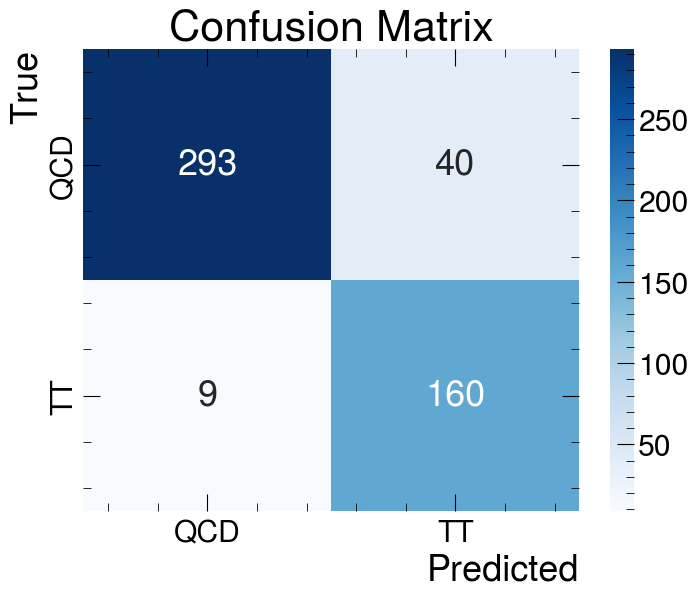

In [12]:
# Load best model
model.load_state_dict(torch.load('best_model.pt'))

# Evaluate on test set
model.eval()
y_true = []
y_pred = []

with torch.no_grad(): 
    for data in val_loader:
        out = model(data.to(device))
        y_true.extend(data.to('cpu').y.numpy())
        y_pred.extend(out.to('cpu').numpy())

y_pred = np.array([x[0] for x in y_pred])
pred_discrete = np.where(y_pred > 0.5, 1, 0)
# Plot confusion matrix
plot_confusion_matrix(y_true, pred_discrete)

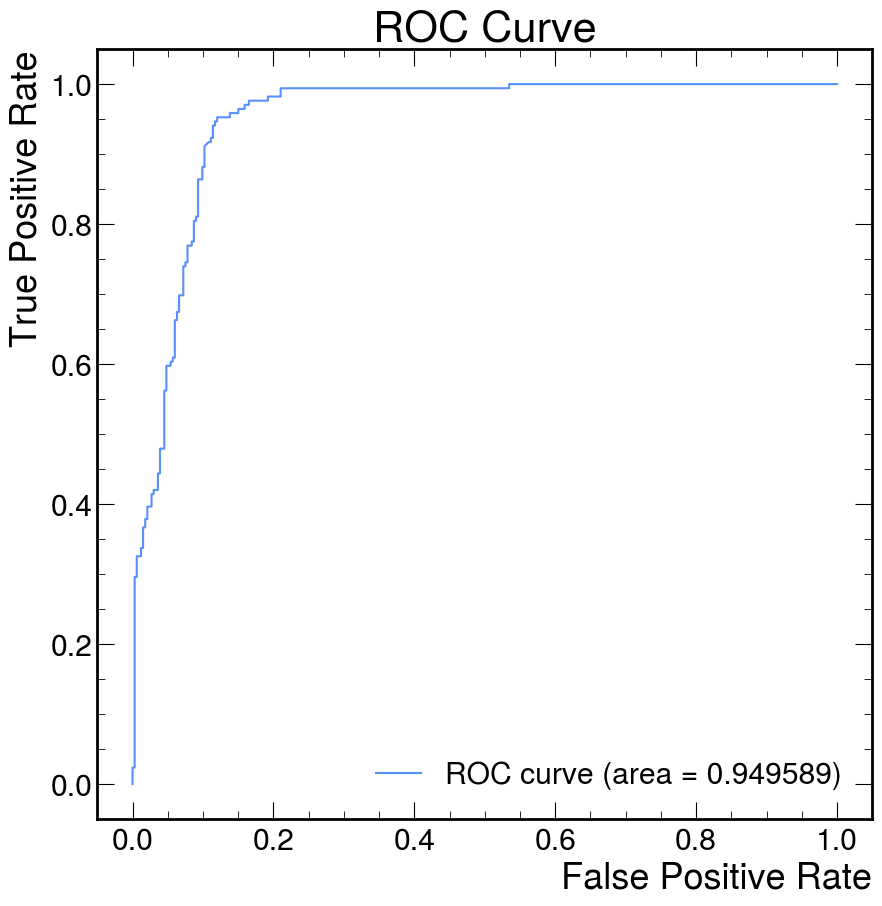

In [13]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_curve(y_true, y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.6f)' % roc_auc)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

plot_roc_curve(y_true, y_pred)

# 5 - Making predictions

In [ ]:
y_pred_test = []
for data in test_loader:
    with torch.no_grad():
        output = model(data.to(device))
        # could you change the prediction threshold? Would that make it better?
        y_pred_test.extend(output.to('cpu').numpy())

y_pred_test = np.array([x[0] for x in y_pred_test])


In [12]:
import pandas as pd
solution = pd.DataFrame({'id':test_ids, 'label':y_pred_test})
solution.to_csv('solution.csv', index=False)